# Data Reduction 2 - ASW

## Introduction

Follow the DR1 Reduction step

**Baseline Correction**

3 different subnotebook
- **ASW**
- C2H6
- C2H6_ASW

## Workflow

**Plan**

- Imports
- Input Parameters
- Load data
- T Ramp for reduction

***


## Imports

Describe the libraries we're using here. If there's something unusual, explain what the library is, and why we need it.

- numpy to handle array functions
- math
- matplotlib.pyplot for plotting data
- pandas
- glob
- functools
- ipywidgets
- ...

Check if they are all of use.


In [1]:
import numpy 
import math
from math import isnan
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.colors as mcolors
import pandas as pd
import glob
from functools import reduce
import ipywidgets as widgets
import matplotlib.gridspec as gridspec
from datetime import datetime
from IPython.core.display import SVG

%matplotlib inline


## Input Parameters

$\color{red}{\text{Implement manually !}}$

In [2]:
# 0.1 Date
date = "2020_09_15"

# 0.2 XP
XP = "XP_1-1"

# 0.3 Sample type
spl = "ASW"

# 0.4 Deposition Temperature
Tdep = "20"

## Load Data

In [3]:
# All_RAW_df

All_RAW_df = pd.read_csv("..\..\DATA\DATA-Processing\PAC\{}/Samples/{}/Data/DR/DR1_{}_All-scans.csv".format(XP,date,date))

All_RAW_df = All_RAW_df.iloc[:,1:]

# data_annex
data_annex_df = pd.read_csv("..\..\DATA\DATA-Processing\PAC\{}/Samples/{}/Data/DR/DR1_{}_data_annex.csv".format(XP,date,date))
                 

In [4]:
#All_RAW_df
data_annex_df

,Name,min1,index1,min2,index2,min3,index3,min4,index4,min5,...,maxA0w,maxBi,maxB,maxBw,maxCi,maxC,maxCw,Int_A,Int_C,Int_N_A
0,ASW_2020_09_15_1,-0.017293,6630,-0.009476,4293,-0.009151,4147,0.001203,2482,0.001967,...,3270.249,2936,0.008422,2215.361,1777,0.022221,1656.579,96.292003,6.703636,100.000000
1,ASW_2020_09_15_2,-0.017489,6636,-0.008995,4161,-0.009001,4132,0.002430,2480,0.003482,...,3246.143,2976,0.012062,2234.646,1754,0.021662,1645.490,111.470194,7.622334,115.762670
2,ASW_2020_09_15_3,-0.017849,6636,-0.009715,4151,-0.009664,4132,0.001595,2463,0.003063,...,3233.125,2974,0.012331,2233.682,1691,0.021226,1615.116,112.359014,8.424437,116.685717
3,ASW_2020_09_15_4,-0.006971,6630,-0.004298,4149,-0.004222,4120,0.002220,2473,0.002968,...,3228.304,2976,0.006884,2234.646,1574,0.013023,1558.708,53.700867,4.010565,55.768771


## T ramp for reduction

$\color{red}{\text{Find a new method to generate Tdictionnary from XP_list_test}}$

to replace the manually done dictionnary:

i = [0,1,2,3]

j = ["20","130","140","160"]

Tdictionary = dict(zip(j, i))


**Generate dictionary from df** <br>
- <a href="https://stackoverflow.com/questions/26716616/convert-a-pandas-dataframe-to-a-dictionary">Stack-Overflow</a>
    

- 1. Slice df to only obtain the date we are interested in - OK
- 2. Set-up date as index - OK
- 3. Transpose - OK
- 4. create a dictionnary - OK

- Select only the second value in list (where multiples item)

### Load

In [5]:
XP_Ramp_df = pd.read_csv('..\..\DATA\DATA-Processing\PAC\XP_list_test.csv')

### Clean

In [6]:
XP_Ramp_df_date = XP_Ramp_df.loc[XP_Ramp_df['Date'] == date]

XP_Ramp_df_date2 = XP_Ramp_df_date.set_index("Date")

#XP_Ramp_df_date2

XP_Ramp_df_T = XP_Ramp_df_date2.T

#XP_Ramp_df_T

XP_Ramp_df_T_f = XP_Ramp_df_T.iloc[1: , :]

#XP_Ramp_df_T_f

XP_Ramp_df_T_f2=XP_Ramp_df_T_f.dropna()

XP_Ramp_df_T_f2

Date,2020_09_15
20,[1]
130,[2]
140,[3]
160,[4]


In [7]:
Tdictionary = XP_Ramp_df_T_f2.to_dict('dict')

Tdictionary

{'2020_09_15': {'20': '[1]', '130': '[2]', '140': '[3]', '160': '[4]'}}

### Sanity Check

In [8]:
#XP_Ramp_df

## <u> Chop the data </u>

Because ASW Sample, Data is choped in 3 range:

- A: OH stretch : (4000 - 2800 cm-1)
- B: Combination bands : (2800 - 1900 cm-1)
- C: Bending modes : (1900 - 800 cm-1)


In [9]:
# OH Stretch

DR1_A_df = All_RAW_df[4150:6639]
#DR1_A_df

# Combination Bands

DR1_B_df = All_RAW_df[2282:4150]
#DR1_B_df

# Bending Modes

DR1_C_df = All_RAW_df[0:2282]
#DR1_C_df

## <u>Background function definition </u>

### Minimum (single point) within a range

Here we select a minimum within a predefined range (stored in data_annex). 


Idea for latter: Try to not select an individual point as minimum but a local minimum with a rolling average

https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.rolling.html

In [17]:
maxA = []
maxAi = []

# We supress the first column (Wavenumber)

DR1_A_df = DR1_A_df.T.iloc[1:].T
DR1_B_df = DR1_B_df.T.iloc[1:].T
DR1_C_df = DR1_C_df.T.iloc[1:].T

# Now compute a new DataFrame indexed by the file names with rows that contain the
# minimum value and the index of that minimum value within specific row ranges
# of the column in data corresponding to the filename.
dataStats = pd.DataFrame.from_dict(
  dict(min1=All_RAW_df.T.iloc[1:].T.iloc[6223:6639].min(axis=0), # min within rows 6000 - end
       mini1=All_RAW_df.T.iloc[1:].T.iloc[6223:6639].idxmin(axis=0), # index of that min
       min2=All_RAW_df.T.iloc[1:].T.iloc[4149:4564].min(axis=0), # min within rows 4000 - 5000
       mini2=All_RAW_df.T.iloc[1:].T.iloc[4149:4564].idxmin(axis=0), # index of that min
       min3=All_RAW_df.T.iloc[1:].T.iloc[3941:4149].min(axis=0), # min within rows 2282 - 2697
       mini3=All_RAW_df.T.iloc[1:].T.iloc[3941:4149].idxmin(axis=0), # index of that min
       min4=All_RAW_df.T.iloc[1:].T.iloc[2282:2490].min(axis=0), # min within rows 415 - 830
       mini4=All_RAW_df.T.iloc[1:].T.iloc[2282:2490].idxmin(axis=0), # index of that min   
       min5=All_RAW_df.T.iloc[1:].T.iloc[2075:2282].min(axis=0), # min within rows 2282 - 2697
       mini5=All_RAW_df.T.iloc[1:].T.iloc[2075:2282].idxmin(axis=0), # index of that min
       min6=All_RAW_df.T.iloc[1:].T.iloc[0:1038].min(axis=0), # min within rows 415 - 830
       mini6=All_RAW_df.T.iloc[1:].T.iloc[0:1038].idxmin(axis=0), # index of that min   
        )
    
)

print(dataStats)

# select average around minimum value 

#.rolling(4).mean()



# Breaking down what's happening in:
# `data.T.iloc[1:].T.iloc[6000:6800].min(axis=0)`
# 1) `data.T.iloc[1:].T` - This is a cheeky way of stripping away the first column, "Wavenumber",
# 1a) `data.T`, transposes the frame i.e. switches rows and columns
# 1b) `.iloc[1:]` selects all but the first row (previously all but the first column).
# 1c) The final `.T` switches rows and columns back again.
# 2) `.iloc[6000:6800]` selects rows at *positions* between 6000 and 6800. We now have a 
# 2D block of data.
# 3) `.min(axis=0)` computes the column-wise minima of the 2D block we just selected, to 
# give us a 1D Series of numbers.
# 3.1) On the next line, `.idxmin(axis=0)` computes the column-wise index of the minimum for 
# the 2D block we just selected, to give us a 1D Series of index locations.

# We want to subtract a linear function from each column in data, that will
# connect the minimum values in the two ranges. 
# We'll use the `apply` method of pd.DataFrame to do that.
# Apply operates on rows (or columns if the argument axis is set to 0) of a Dataframe to 
# compute a function on the elements of that whole row or column.
#
# We'll define the function that we want to compute.
# The first argument is the column or row data themselves and we are free to 
# provide other data that we need to compute out function.
def computeLinearBackground1(values,     # The column values (e.g. Y)
                            waveNumber, # The corresponding wavenumbers (e.g. X)
                            valueStats  # The dataframe containing the minima and their 
                                        # indices for each file
                 ):
    # extract the correct set of minima using the `name` attribute of the `values` series
    # to index the `valueStats` frame.
    stats = valueStats.loc[values.name, :]
    # compute a linear background function
    gradient = ((stats.min1 - stats.min2)/(stats.mini1 - stats.mini2))
    intercept = stats.min1 - stats.mini1*gradient
    linearBackground1 = (gradient * waveNumber.index) + intercept
    # subtract that function from the column values
    return linearBackground1

def computeLinearBackground2(values,    
                            waveNumber, 
                            valueStats  
                                        
                 ):

    stats = valueStats.loc[values.name, :]
    gradient = ((stats.min3 - stats.min4)/(stats.mini3 - stats.mini4))
    intercept = stats.min3 - stats.mini3*gradient
    linearBackground2 = (gradient * waveNumber.index) + intercept
    return linearBackground2



def computeLinearBackground3(values,   
                            waveNumber, 
                            valueStats  
                 ):
    
    stats = valueStats.loc[values.name, :]
    gradient = ((stats.min5 - stats.min6)/(stats.mini5 - stats.mini6))
    intercept = stats.min5 - stats.mini5*gradient
    linearBackground3 = (gradient * waveNumber.index) + intercept
    return linearBackground3

# Finally apply our function to the columns of the dataframe (except the wavenumber column)
# We specify axis=0 to operate on the columns (confusingly this is referred to as *along*
# the index direction in the docs), and pass the first (wavenumber) column and the summary 
# statistics dataframe, wrapped in a tuple, as the `args` argument.
backgroundsA = DR1_A_df.T.iloc[0:].T.apply(computeLinearBackground1, axis=0, args=(DR1_A_df.T.iloc[0], dataStats))
backgroundsB = DR1_B_df.T.iloc[0:].T.apply(computeLinearBackground2, axis=0, args=(DR1_B_df.T.iloc[0], dataStats))
backgroundsC = DR1_C_df.T.iloc[0:].T.apply(computeLinearBackground3, axis=0, args=(DR1_C_df.T.iloc[0], dataStats))


                      min1  mini1      min2  mini2      min3  mini3      min4  \
ASW_2020_09_15_1 -0.017293   6630 -0.009476   4293 -0.009151   4147  0.001203   
ASW_2020_09_15_2 -0.017489   6636 -0.008995   4161 -0.009001   4132  0.002430   
ASW_2020_09_15_3 -0.017849   6636 -0.009715   4151 -0.009664   4132  0.001595   
ASW_2020_09_15_4 -0.006971   6630 -0.004298   4149 -0.004222   4120  0.002220   

                  mini4      min5  mini5      min6  mini6  
ASW_2020_09_15_1   2482  0.001967   2281  0.008001    490  
ASW_2020_09_15_2   2480  0.003482   2281  0.009177    474  
ASW_2020_09_15_3   2463  0.003063   2269  0.007827    476  
ASW_2020_09_15_4   2473  0.002968   2279  0.006000    829  


### Sanity Check

In [18]:
#DR1_A_df

## <u>Baseline correction</u>

### data - background subtraction 

In [19]:
dataA_BC = pd.DataFrame(DR1_A_df - backgroundsA)
dataB_BC = pd.DataFrame(DR1_B_df - backgroundsB)
dataC_BC = pd.DataFrame(DR1_C_df - backgroundsC)


### Cleaning and Sanity Check

We reinsert the Wavenumber that was removed prior to the baseline function aplied

In [20]:
# dataA_BC_U
# dataB_BC_U
# dataC_BC_U

In [21]:
dataA_BC.insert(0, 'Wavenumber', All_RAW_df['Wavenumber'])
dataB_BC.insert(0, 'Wavenumber', All_RAW_df['Wavenumber'])
dataC_BC.insert(0, 'Wavenumber', All_RAW_df['Wavenumber'])

backgroundsA.insert(0, 'Wavenumber', All_RAW_df['Wavenumber'])
backgroundsB.insert(0, 'Wavenumber', All_RAW_df['Wavenumber'])
backgroundsC.insert(0, 'Wavenumber', All_RAW_df['Wavenumber'])

#### Concatenation

In [22]:
All_data_A = dataC_BC.append(dataB_BC).drop_duplicates().reset_index(drop=True)
All_data_BC = All_data_A.append(dataA_BC).drop_duplicates().reset_index(drop=True)

In [23]:
#All_data_BC

#### Export as csv

Not up to date

In [24]:
All_data_BC.to_csv('../../DATA\DATA-Processing\PAC\{}/Samples/{}/Data/DR/DR2_{}_All-scans.csv'.format(XP, date, date))

## <u>Max Absorbance</u>

### Preliminary work

A first step in our analysis is to extract and use the maximum absorbance in order to make a first comparison of the frequency shifts with respect to temperature for each sample.

#### Range B

For range B (combination modes), we need to supress the CO2 signature (that would otherwise contribute to the max A value for this range). As a first guess we aim to supress data from 2390 to 2290 wavenumber

#### Range C

Concerning range C, we are only aiming for the maximum absorbance of the bending modes but the libration modes have a contribution more important. However the peak is incomplete and we need to supress it. <br>
Same approach as previously will be used and we aim to cut the data at wavenumber = 1040 cm-1

In [25]:
dataB_BC_U = dataB_BC.drop(dataB_BC.index[808:1016])
dataC_BC_U = dataC_BC.drop(dataC_BC.index[0:498])

###  Extract max A

Here we look for 4 maximum:
- two for the range A (1 with the baseline corrected scan and one from the unreduced data, to check that they concord and that the reduction routine does not affect the spectral signature)
- one for range B (using dataB_BC_U that excude the CO2 signature)
- one for range C (using dataC_BC_U that excude the libration modes)

In [26]:
#Data max from unreduced data in range A 

dataA_Max = pd.DataFrame.from_dict(
  dict(maxA0=DR1_A_df.T.iloc[0:].T.iloc[0:].max(axis=0), # min within rows 6000 - end
       maxA0i=DR1_A_df.T.iloc[0:].T.iloc[0:].idxmax(axis=0),  

        )
)

#Data max from Baseline Corrected Data in range A 

dataA_BC_Max = pd.DataFrame.from_dict(
  dict(maxA=dataA_BC.T.iloc[1:].T.iloc[1:].max(axis=0), # min within rows 6000 - end
       maxAi=dataA_BC.T.iloc[1:].T.iloc[1:].idxmax(axis=0),  

        )
)

#Data max from Baseline Corrected Data in range B

dataB_BC_Max = pd.DataFrame.from_dict(
  dict(maxB=dataB_BC_U.T.iloc[1:].T.iloc[1:].max(axis=0), # min within rows 6000 - end
       maxBi=dataB_BC_U.T.iloc[1:].T.iloc[1:].idxmax(axis=0),  

        )
)

#Data max from Baseline Corrected Data in range C

dataC_BC_Max = pd.DataFrame.from_dict(
  dict(maxC=dataC_BC_U.T.iloc[1:].T.iloc[1:].max(axis=0), # min within rows 6000 - end
       maxCi=dataC_BC_U.T.iloc[1:].T.iloc[1:].idxmax(axis=0),  

        )
)




### Clean 

In [27]:
wavelength = All_RAW_df.T.iloc[0]

# A DR2

dataA_BC_Max = dataA_BC_Max.reset_index()
dataA_BC_Max['Name'] = dataA_BC_Max['index']
dataA_BC_Max = dataA_BC_Max.T.iloc[1:].T

dataA_BC_Max1 = dataA_BC_Max.set_index('maxAi',drop=True)
dataA_BC_Max2 = dataA_BC_Max1.join(wavelength, on='maxAi')
dataA_BC_Max2 = dataA_BC_Max2.reset_index()
dataA_BC_Max_F = dataA_BC_Max2.set_index(dataA_BC_Max.index)
dataA_BC_Max_F.rename(columns={'Wavenumber': 'maxAw'}, inplace=True)

# A DR1

dataA_Max = dataA_Max.reset_index()
dataA_Max['Name'] = dataA_Max['index']
dataA_Max = dataA_Max.T.iloc[1:].T

dataA_Max1 = dataA_Max.set_index('maxA0i',drop=True)
dataA_Max2 = dataA_Max1.join(wavelength, on='maxA0i')
dataA_Max2 = dataA_Max2.reset_index()
dataA_Max_F = dataA_Max2.set_index(dataA_Max.index)
dataA_Max_F.rename(columns={'Wavenumber': 'maxA0w'}, inplace=True)

# B DR2



dataB_BC_Max = dataB_BC_Max.reset_index()
dataB_BC_Max['Name'] = dataB_BC_Max['index']
dataB_BC_Max = dataB_BC_Max.T.iloc[1:].T

dataB_BC_Max1 = dataB_BC_Max.set_index('maxBi',drop=True)
dataB_BC_Max2 = dataB_BC_Max1.join(wavelength, on='maxBi')
dataB_BC_Max2 = dataB_BC_Max2.reset_index()
dataB_BC_Max_F = dataB_BC_Max2.set_index(dataB_BC_Max.index)
dataB_BC_Max_F.rename(columns={'Wavenumber': 'maxBw'}, inplace=True)

# C DR2

dataC_BC_Max = dataC_BC_Max.reset_index()
dataC_BC_Max['Name'] = dataC_BC_Max['index']
dataC_BC_Max = dataC_BC_Max.T.iloc[1:].T

dataC_BC_Max1 = dataC_BC_Max.set_index('maxCi',drop=True)
dataC_BC_Max2 = dataC_BC_Max1.join(wavelength, on='maxCi')
dataC_BC_Max2 = dataC_BC_Max2.reset_index()
dataC_BC_Max_F = dataC_BC_Max2.set_index(dataC_BC_Max.index)
dataC_BC_Max_F.rename(columns={'Wavenumber': 'maxCw'}, inplace=True)

In [28]:
#dataA_Max_F

___Insert column scan number___ 

to be able to link data_annex with XP_Ramp_df

In [29]:
nscan = len(list(dataA_BC_Max_F.index.values.tolist()))
scan_number = pd.Series(range(1,nscan+1))
scan_number.astype(int)

0    1
1    2
2    3
3    4
dtype: int32

In [30]:
dataA_BC_Max_F['scan_number'] = scan_number

###  Append to data Annex

In [38]:
data_annex_df = pd.merge(data_annex_df, dataA_BC_Max_F, on="Name")
data_annex_df = pd.merge(data_annex_df, dataA_Max_F, on="Name")
data_annex_df = pd.merge(data_annex_df, dataB_BC_Max_F, on="Name")
data_annex_df = pd.merge(data_annex_df, dataC_BC_Max_F, on="Name")


Data annex already complete for most of the samples

### Sanity Check

In [39]:
data_annex_df

,Name,min1,index1,min2,index2,min3,index3,min4,index4,min5,...,scan_number_y,maxA0i_y,maxA0_y,maxA0w_y,maxBi_y,maxB_y,maxBw_y,maxCi_y,maxC_y,maxCw_y
0,ASW_2020_09_15_1,-0.017293,6630,-0.009476,4293,-0.009151,4147,0.001203,2482,0.001967,...,1,5124,0.277977,3270.249,2936,0.00842242,2215.361,1777,0.0222207,1656.579
1,ASW_2020_09_15_2,-0.017489,6636,-0.008995,4161,-0.009001,4132,0.002430,2480,0.003482,...,2,5074,0.39589,3246.143,2976,0.0120615,2234.646,1754,0.0216619,1645.490
2,ASW_2020_09_15_3,-0.017849,6636,-0.009715,4151,-0.009664,4132,0.001595,2463,0.003063,...,3,5047,0.400649,3233.125,2974,0.0123309,2233.682,1691,0.0212264,1615.116
3,ASW_2020_09_15_4,-0.006971,6630,-0.004298,4149,-0.004222,4120,0.002220,2473,0.002968,...,4,5037,0.20309,3228.304,2976,0.00688415,2234.646,1574,0.0130229,1558.708


## <u>Plotting</u> 

### Full range 

In [41]:
nscan = len(list(dataA_BC.columns.values.tolist()))

ymax =   data_annex_df.iloc[1:,16].astype(float).max()
ymin =   data_annex_df.iloc[1:,16].astype(float).min()
ymax2 = ymax + 0.01
ymin2 = ymin - 0.01 

5


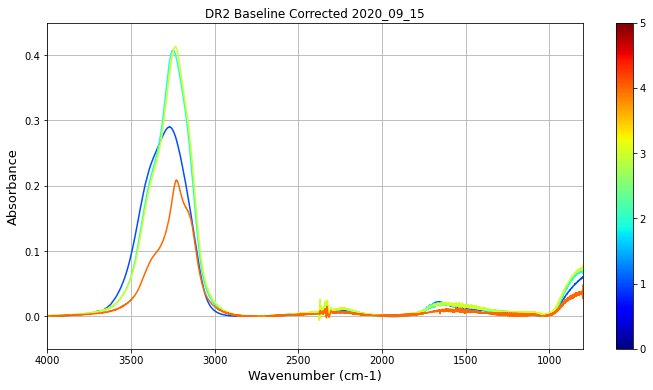

In [42]:
nscan = len(list(All_RAW_df.columns.values.tolist()))

print(nscan)


fig= plt.figure(figsize=(12,6))


normalize = mcolors.Normalize(vmin=0, vmax=nscan)
colormap = cm.jet
i=1

for i in range(1,nscan):
    
    plt.plot(All_data_BC.Wavenumber, All_data_BC['{}_{}_{}'.format(spl, date, i)], color=colormap(normalize(i)))
    
    i=+1
    

plt.title('DR2 Baseline Corrected {0}'.format(date))
plt.axis([4000,800,-0.05,0.45])
plt.xlabel('Wavenumber (cm-1)').set_fontsize(13)
plt.ylabel('Absorbance').set_fontsize(13)
#ax = fig.gca()
plt.grid()
#plt.legend()

scalarmappaple = cm.ScalarMappable(norm=normalize, cmap=colormap)
scalarmappaple.set_array(nscan)
plt.colorbar(scalarmappaple)

#plt.savefig('D:\DATA-Processing\PAC\{}/Samples/{}/Plots/DR/DR2_{}_Full-range.png'.format(XP, date, date))

plt.show()

###  Oh stretch

#### Baseline correction

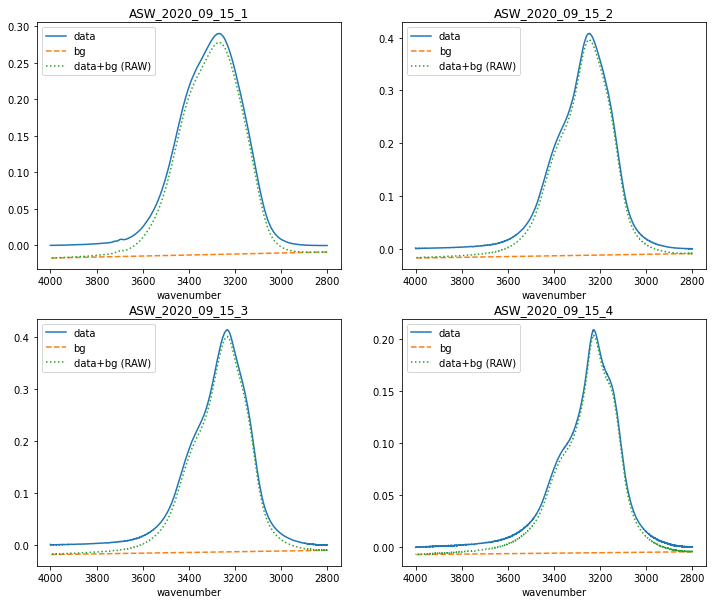

In [44]:
nscan = len(list(dataA_BC.columns.values.tolist()))

nscan2 = nscan//int(2)
nscan1 = nscan2*int(5)

figure, panels = plt.subplots(figsize=(12, nscan1), ncols=2, nrows=nscan2)

for panel, column in zip(panels.flatten(), dataA_BC.columns[1:]):
    panel.plot(dataA_BC.Wavenumber, dataA_BC[column], label="data")
    panel.plot(dataA_BC.Wavenumber, backgroundsA[column], ls="dashed",  label="bg")

    panel.plot(dataA_BC.Wavenumber, dataA_BC[column]+ backgroundsA[column], ls="dotted",  label="data+bg (RAW)")

    
    
    #panel.legend()
    panel.set_xlabel("wavenumber")
    panel.invert_xaxis()
    panel.set_title(column)
    panel.legend()
    
    #plt.savefig('D:\DATA-Processing\PAC\{}/Samples/{}/Plots/DR/DR2_{}_BCA.png'.format(XP, date, date))

    
plt.show()
    
    
#plt.tight_layout()
    

####  All scans 

(using scan number - All data)
<br>
Idea for later : plot OH and maxA together

[Marker modification](https://matplotlib.org/stable/api/markers_api.html)

No handles with labels found to put in legend.


5


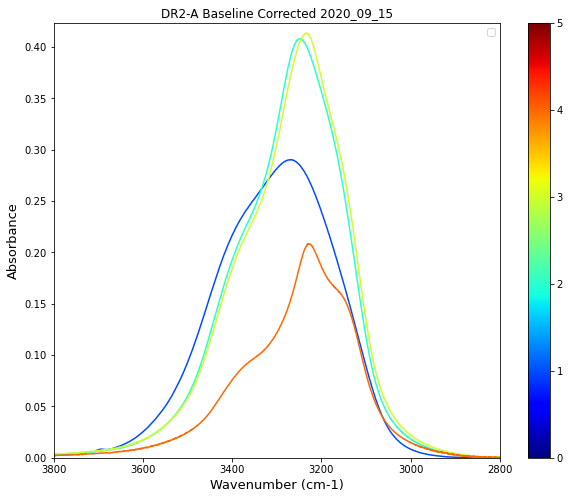

In [45]:
nscan = len(list(All_RAW_df.columns.values.tolist()))

print(nscan)


fig= plt.figure(figsize=(10,8))


normalize = mcolors.Normalize(vmin=0, vmax=nscan)
colormap = cm.jet
i=1

for i in range(1,nscan):
    
    plt.plot(dataA_BC.Wavenumber, dataA_BC['{}_{}_{}'.format(spl, date, i)], color=colormap(normalize(i)))
    
    i=+1
    

plt.title('DR2-A Baseline Corrected {0}'.format(date))
plt.axis([3800,2800,0,ymax2])
plt.xlabel('Wavenumber (cm-1)').set_fontsize(13)
plt.ylabel('Absorbance').set_fontsize(13)
#ax = fig.gca()
#plt.grid()
plt.legend()

scalarmappaple = cm.ScalarMappable(norm=normalize, cmap=colormap)
scalarmappaple.set_array(nscan)
plt.colorbar(scalarmappaple)

#plt.savefig('D:\DATA-Processing\PAC\{}/Samples/{}/Plots/DR/DR2_{}_A.png'.format(XP, date, date))

plt.show()

#### 2.4.A.4b All scans (using dictionnary vale - discrete T)

later

#### 2.4.A.4 Max Absorbance (peak frequency shift) - Clean

In [48]:
fig= plt.figure(figsize=(10,8))

for keys, values in Tdictionary.items():

    plt.plot(keys, data_annex_df.iloc[values,17], '+', mew=3, ms=12, c=cm.jet(values/nscan),label= str(keys)+" - "+str(values+1)+" - "+str(int(data_anex_df.iloc[values,17])))
    plt.plot(keys, data_annex_df.iloc[values,21], '.', mew=3, ms=12, c=cm.jet(values/nscan),label= str(keys)+" - "+str(values+1)+" - "+str(int(data_anex_df.iloc[values,21])))

plt.title('{0} DR2 OH stretch Peak frequency (DR1-DR2 comparison)'.format(date))
#plt.axis([3210,3270])
plt.xlabel('Temperature (K)').set_fontsize(13)
plt.ylabel('Peak frequency (cm-1)').set_fontsize(13)
#ax = fig.gca()
#plt.grid()
plt.legend()


#plt.savefig('D:\DATA-Processing\PAC\{}/Samples/{}/Plots/DR/DR2_{}_PeakA-frequency_wA0.png'.format(XP, date, date))

plt.show()

IndexError: .iloc requires numeric indexers, got {'20': '[1]', '130': '[2]', '140': '[3]', '160': '[4]'}

<Figure size 720x576 with 0 Axes>

#### 2.4.A.5 Max Absorbance (peak frequency shift) - Isotherm 1

In [49]:
if Iso == True:

    fig = plt.figure(figsize=(8,6))

    for keys, values in Isodic1.items():

        plt.plot(keys, data_anex_df.iloc[values,17], '+', mew=3, ms=12, c=cm.jet(values/nscan),label= str(keys)+" - "+str(values+1)+" - "+str(int(data_anex_df.iloc[values,17])))
        
    plt.title('{0} DR2 OH stretch Peak frequency Isotherm at {1} K'.format(date,Tiso1))
    #plt.axis([3210,3270])
    plt.xlabel('Time (h)').set_fontsize(13)
    plt.ylabel('Peak frequency (cm-1)').set_fontsize(13)
    ax = fig.gca()
    ax.xaxis.set_major_locator(plt.MaxNLocator(10))    
    #plt.grid()
    #plt.legend()


    #plt.savefig('D:\DATA-Processing\PAC\{}/Samples/{}/Plots/DR/DR2_{}_PeakA-frequency_Iso_{}.png'.format(XP, date, date, Tiso1))

    plt.show()

NameError: name 'Iso' is not defined

In [50]:
if Iso == True:

    fig = plt.figure(figsize=(8,6))

    for keys, values in Isodic1.items():

        plt.plot(keys, data_anex_df.iloc[values,16], '+', mew=3, ms=12, c=cm.jet(values/nscan),label= str(keys)+" - "+str(values+1)+" - "+str(int(data_anex_df.iloc[values,17])))
        
    plt.title('{0} DR2 Max A Isotherm at {1} K'.format(date,Tiso1))
    #plt.axis([3210,3270])
    plt.xlabel('Time (h)').set_fontsize(13)
    plt.ylabel('Peak frequency (cm-1)').set_fontsize(13)
    ax = fig.gca()
    ax.xaxis.set_major_locator(plt.MaxNLocator(10))    
    #plt.grid()
    #plt.legend()


    plt.savefig('D:\DATA-Processing\PAC\{}/Samples/{}/Plots/DR/DR2_{}_max_A_Iso_{}.png'.format(XP, date, date, Tiso1))

    plt.show()

NameError: name 'Iso' is not defined

###  2.4.B Comb Bands

#### 2.4.B.1 Baseline correction

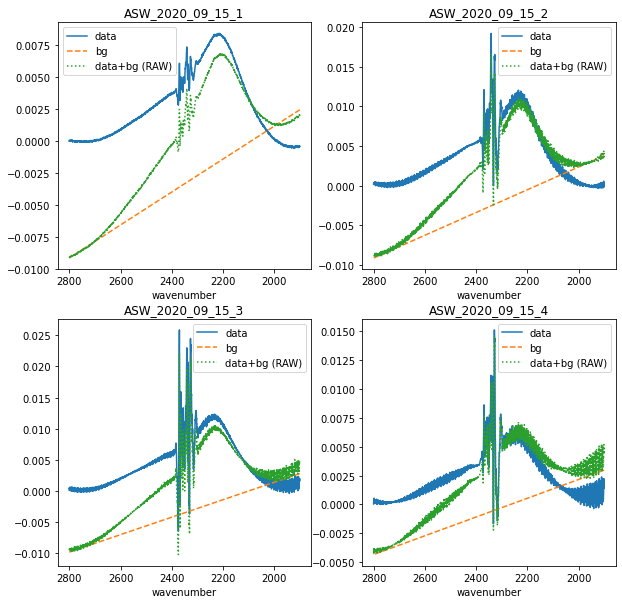

In [52]:
nscan = len(list(dataB_BC.columns.values.tolist()))

nscan2 = nscan//int(2)
nscan1 = nscan2*int(5)

figure, panels = plt.subplots(figsize=(10, nscan1), ncols=2, nrows=nscan2)

for panel, column in zip(panels.flatten(), dataB_BC.columns[1:]):
    panel.plot(dataB_BC.Wavenumber, dataB_BC[column], label="data")
    panel.plot(dataB_BC.Wavenumber, backgroundsB[column], ls="dashed",  label="bg")

    panel.plot(dataB_BC.Wavenumber, dataB_BC[column] + backgroundsB[column], ls="dotted",  label="data+bg (RAW)")

    
    
    #panel.legend()
    panel.set_xlabel("wavenumber")
    panel.set_title(column)
    panel.invert_xaxis()
    panel.legend()
    
    #plt.savefig('D:\DATA-Processing\PAC\{}/Samples/{}/Plots/DR/DR2_{}_BCB.png'.format(XP, date, date))

    
plt.show()
    
    
#plt.tight_layout()
    

#### 2.4.B.3 All scans

5


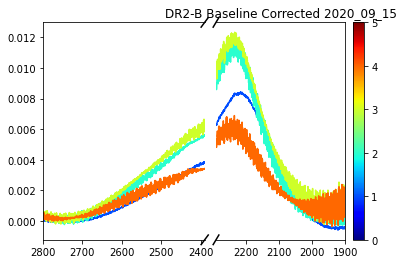

In [53]:
nscan = len(list(All_RAW_df.columns.values.tolist()))

print(nscan)


f,(ax,ax2) = plt.subplots(1,2,sharey=True)



normalize = mcolors.Normalize(vmin=0, vmax=nscan)
colormap = cm.jet

i=1

for i in range(1,nscan):
    
    ax.plot(dataB_BC_U.Wavenumber, dataB_BC_U['{}_{}_{}'.format(spl, date, i)], color=colormap(normalize(i)))
    ax2.plot(dataB_BC_U.Wavenumber, dataB_BC_U['{}_{}_{}'.format(spl, date, i)], color=colormap(normalize(i)))
    
    i=+1
    

ax.set_xlim(2800,2390)
ax2.set_xlim(2290,1900)

ax.spines['right'].set_visible(False)
ax2.spines['left'].set_visible(False)

ax.yaxis.tick_left()
ax2.yaxis.set_visible(False)

d = .022 # how big to make the diagonal lines in axes coordinates
# arguments to pass plot, just so we don't keep repeating them
kwargs = dict(transform=ax.transAxes, color='k', clip_on=False)
ax.plot((1-d,1+d), (-d,+d), **kwargs)
ax.plot((1-d,1+d),(1-d,1+d), **kwargs)

kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
ax2.plot((-d,+d), (1-d,1+d), **kwargs)
ax2.plot((-d,+d), (-d,+d), **kwargs)

f.subplots_adjust(wspace=.070)

plt.title('DR2-B Baseline Corrected {0}'.format(date))
#plt.axis([2800,1900,0,0.015])
#plt.xlabel('Wavenumber (cm-1)').set_fontsize(13)
#plt.ylabel('Absorbance').set_fontsize(13)
#ax = fig.gca()
#plt.grid()
#plt.legend()

scalarmappaple = cm.ScalarMappable(norm=normalize, cmap=colormap)
scalarmappaple.set_array(nscan)
plt.colorbar(scalarmappaple)

#plt.savefig('D:\DATA-Processing\PAC\{}/Samples/{}/Plots/DR/DR2_{}_B.png'.format(XP, date, date))

plt.show()

#### 2.4.B.4 Max A + Redshift

In [56]:
fig= plt.figure(figsize=(10,8))

for keys, values in Tdictionary.items():

    plt.plot(keys, data_annex_df.iloc[values,24], '+', mew=3, ms=12, c=cm.jet(values/nscan),label= str(keys)+" - "+str(values+1)+" - "+str(int(data_anex_df.iloc[values,24])))
    #plt.plot(keys, data_anex_df.iloc[values,21], '.', mew=3, ms=12, c=cm.jet(values/nscan),label= str(keys)+" - "+str(values+1)+" - "+str(int(data_anex_df.iloc[values,21])))

plt.title('{0} DR2_B Peak frequency'.format(date))
#plt.axis([3210,3270])
plt.xlabel('Temperature (K)').set_fontsize(13)
plt.ylabel('Peak frequency (cm-1)').set_fontsize(13)
#ax = fig.gca()
#plt.grid()
plt.legend()


plt.savefig('D:\DATA-Processing\PAC\{}/Samples/{}/Plots/DR/DR2_{}_PeakB-frequency.png'.format(XP, date, date))

plt.show()

IndexError: .iloc requires numeric indexers, got {'20': '[1]', '130': '[2]', '140': '[3]', '160': '[4]'}

<Figure size 720x576 with 0 Axes>

###  2.4.C Bending

#### 2.4.B.1 Baseline correction

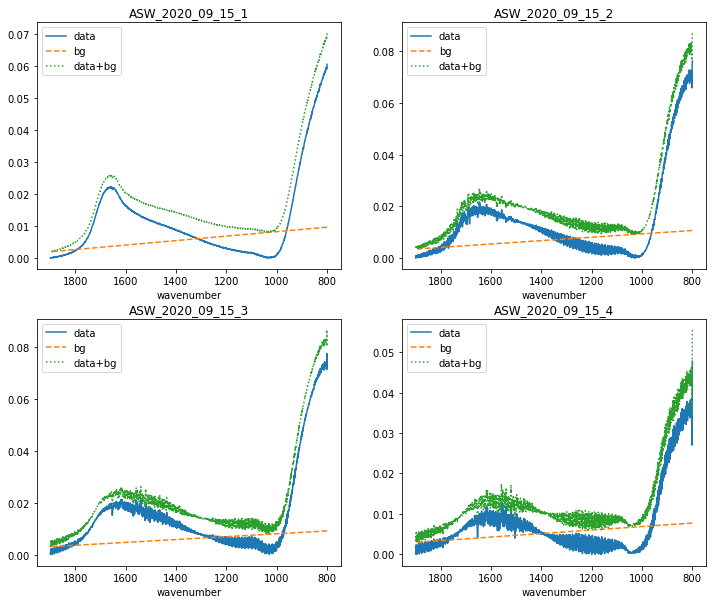

In [57]:
nscan = len(list(dataC_BC.columns.values.tolist()))

nscan2 = nscan//int(2)
nscan1 = nscan2*int(5)

figure, panels = plt.subplots(figsize=(12, nscan1), ncols=2, nrows=nscan2)

for panel, column in zip(panels.flatten(), dataC_BC.columns[1:]):
    panel.plot(dataC_BC.Wavenumber, dataC_BC[column], label="data")
    panel.plot(dataC_BC.Wavenumber, backgroundsC[column], ls="dashed",  label="bg")

    panel.plot(dataC_BC.Wavenumber, dataC_BC[column]+ backgroundsC[column], ls="dotted",  label="data+bg")

    
    
    #panel.legend()
    panel.set_xlabel("wavenumber")
    panel.invert_xaxis()
    panel.set_title(column)
    panel.legend()
    
    #plt.savefig('D:\DATA-Processing\PAC\{}/Samples/{}/Plots/DR/DR2_{}_BCC.png'.format(XP, date, date))

    
plt.show()
    
    
#plt.tight_layout()
    

#### 2.4.B.3 All scans

In [59]:
nscan = len(list(dataC_BC.columns.values.tolist()))

ymax =   data_annex_df.iloc[1:,23].astype(float).max()
ymin =   data_annex_df.iloc[1:,23].astype(float).min()
ymax2 = ymax + 0.005
ymin2 = ymin - 0.01 

No handles with labels found to put in legend.


5


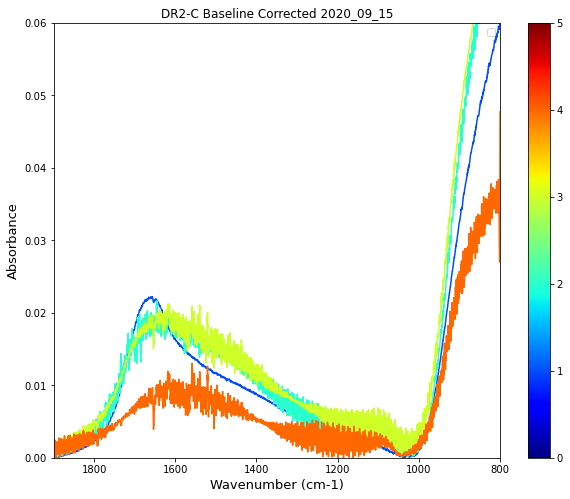

In [61]:
nscan = len(list(All_RAW_df.columns.values.tolist()))

print(nscan)


fig= plt.figure(figsize=(10,8))


normalize = mcolors.Normalize(vmin=0, vmax=nscan)
colormap = cm.jet
i=1

for i in range(1,nscan):
    
    plt.plot(dataC_BC.Wavenumber, dataC_BC['{}_{}_{}'.format(spl, date, i)], color=colormap(normalize(i)))
    
    i=+1
    

plt.title('DR2-C Baseline Corrected {0}'.format(date))
plt.axis([1900,800,0,0.06])
plt.xlabel('Wavenumber (cm-1)').set_fontsize(13)
plt.ylabel('Absorbance').set_fontsize(13)
#ax = fig.gca()
#plt.grid()
plt.legend()

scalarmappaple = cm.ScalarMappable(norm=normalize, cmap=colormap)
scalarmappaple.set_array(nscan)
plt.colorbar(scalarmappaple)

#plt.savefig('D:\DATA-Processing\PAC\{}/Samples/{}/Plots/DR/DR2_{}_C.png'.format(XP, date, date))

plt.show()

Plot the unreduced (BC) scans to see if a polynomial would be better

No handles with labels found to put in legend.


5


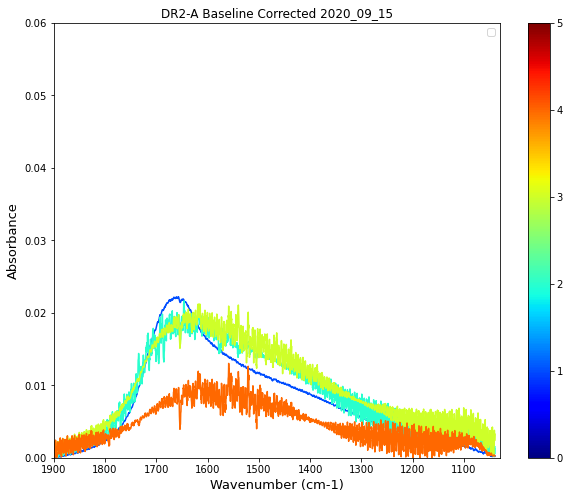

In [62]:
nscan = len(list(All_RAW_df.columns.values.tolist()))

print(nscan)


fig= plt.figure(figsize=(10,8))


normalize = mcolors.Normalize(vmin=0, vmax=nscan)
colormap = cm.jet
i=1

for i in range(1,nscan):
    
    plt.plot(dataC_BC_U.Wavenumber, dataC_BC_U['{}_{}_{}'.format(spl, date, i)], color=colormap(normalize(i)))
    
    i=+1
    

plt.title('DR2-A Baseline Corrected {0}'.format(date))
plt.axis([1900,1030,0,0.06])
plt.xlabel('Wavenumber (cm-1)').set_fontsize(13)
plt.ylabel('Absorbance').set_fontsize(13)
#ax = fig.gca()
#plt.grid()
plt.legend()

scalarmappaple = cm.ScalarMappable(norm=normalize, cmap=colormap)
scalarmappaple.set_array(nscan)
plt.colorbar(scalarmappaple)

#plt.savefig('D:\DATA-Processing\PAC\{}/Samples/{}/Plots/DR/DR2_{}_C_U.png'.format(XP, date, date))

plt.show()

***

<img style="float: right;" src="..\..\Docs\Logo_work_in_progress.svg" alt="logo" width="160px"/>

## About this notebook

**Updated On:** 2022-10-11 


**Author:** Vincent Deguin, PhD Student.
<br>
 **Contact:** vincent.deguin@open.ac.uk  

